In [1]:
from impdar.lib import load, gpslib
from impdar.lib import plot
import numpy as np

In [2]:
radar_lines = load.load('bsi', 'jif2021.h5')

Loading line_0 from jif2021.h5
Interpolating traces with bad GPS in line_0
Loading line_1 from jif2021.h5
Interpolating traces with bad GPS in line_1


## Take a look at what we have
Sometimes, before we even look at what the radar data are, we need to figure out where on earth they are from. In this case, I saw that it was in Alaska so chose an Alaska Albers projection. You can always start with PlateCarree/Mercator

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

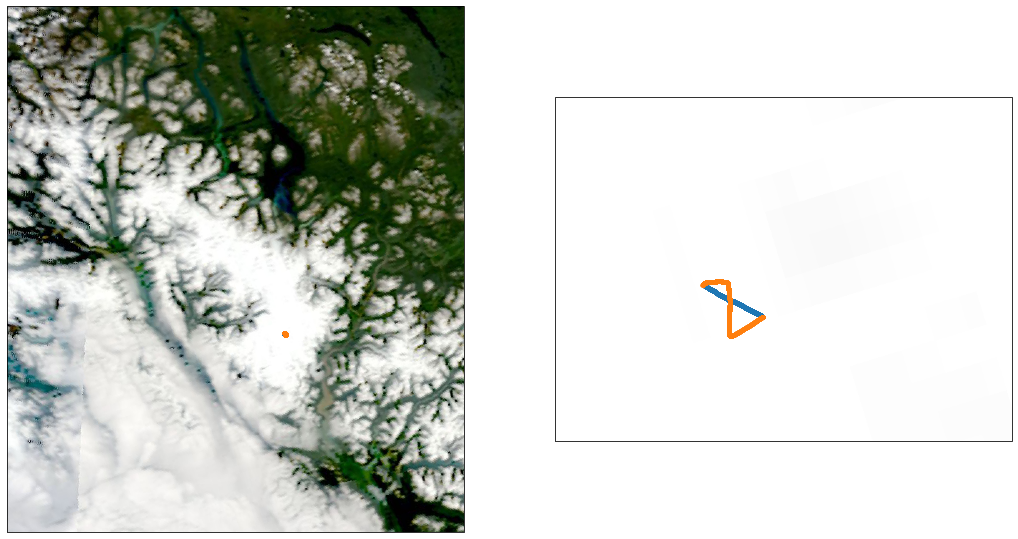

In [4]:
# This cell will require cartopy and owslib, both can be installed with pip
import cartopy.crs as ccrs
from owslib.wmts import WebMapTileService

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # we get some annoying stuff from owslib here otherwise
    # URL of NASA GIBS
    url = 'https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/wmts.cgi'
    wmts = WebMapTileService(url)
    # Layers for MODIS true color and snow RGB
    layer = 'MODIS_Terra_SurfaceReflectance_Bands143'
    date_str = '2021-07-04'

    # Extents near JI
    rough_extents = [-136, -133, 58, 60]
    fine_extents = [-134.25, -134.15, 58.64, 58.67]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12), subplot_kw={'projection': ccrs.epsg(3338)})
    ax1.set_extent(rough_extents, crs=ccrs.PlateCarree())
    ax2.set_extent(fine_extents, crs=ccrs.PlateCarree())
    for ax in (ax1, ax2):
        ax.add_wmts(wmts, layer, wmts_kwargs={'time': date_str})
        for line in radar_lines:
            ax.plot(line.long, line.lat, linestyle='none', marker='.', transform=ccrs.PlateCarree())

## Processing
Firs we need to determine what is needed. To start, let's plot the data and see what it looks like.

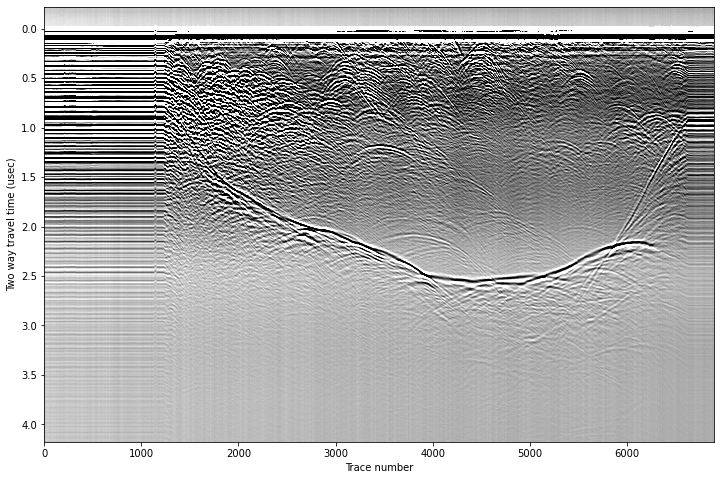

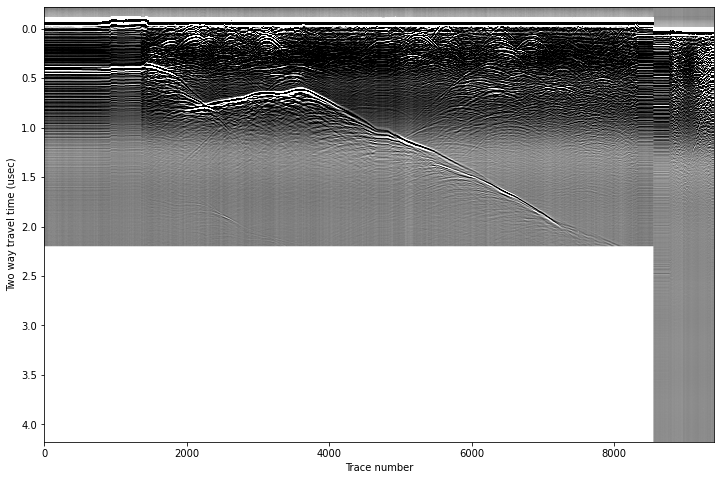

In [5]:
for line in radar_lines:
    plot.plot_radargram(line)

### Cropping
The second line is a bit funky--a result of changing settings mid-acquisition. As a first step, I like to break things up into logical chunks. In this case, that means splitting the second file and removing the part with no returns. ImpDAR does not have a 'split' method--it is not that common an operation--so instead we copy the second line then crop it two different ways.

In [6]:
import copy 
cropped_lines = [copy.deepcopy(radar_lines[0]), copy.deepcopy(radar_lines[1]), copy.deepcopy(radar_lines[1])]
cropped_lines[1].hcrop(8548, 'right', 'tnum')
cropped_lines[1].crop(1100, 'bottom', 'snum')
cropped_lines[2].hcrop(8548, 'left', 'tnum')

Vertical samples reduced to subset [0:1100] of original


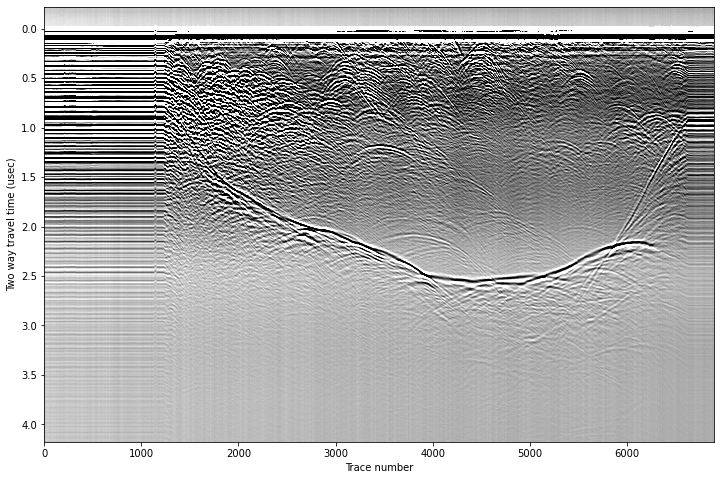

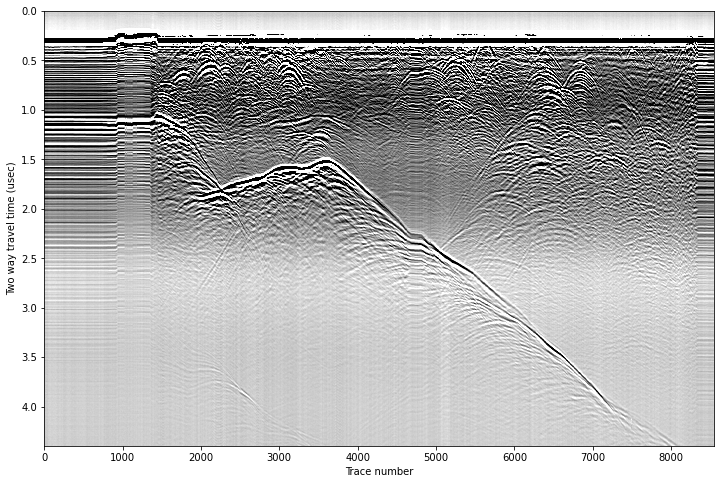

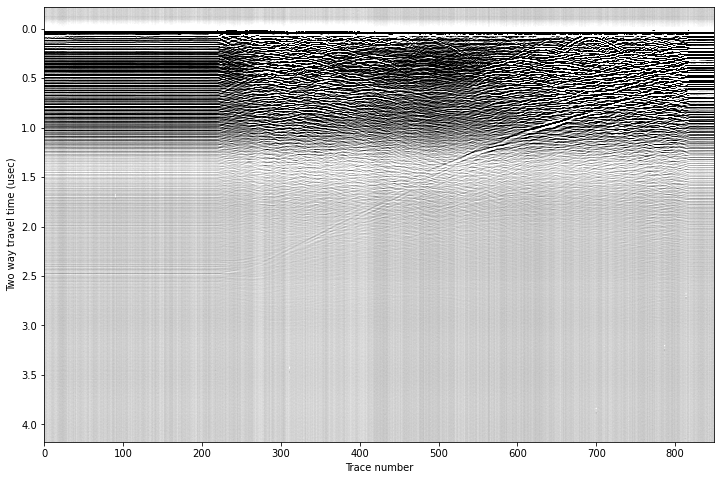

In [7]:
for line in cropped_lines:
    plot.plot_radargram(line)

## Filter in the vertical
We generally should do any vertical filtering before we mix neighboring traces together in order to avoid interference-like effects. Here we are going to do a bandpass filter. Since I am not familiar with this system, I will begin by figuring out its frequency.

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:xlabel='Freq (MHz)', ylabel='Power spectral density'>)

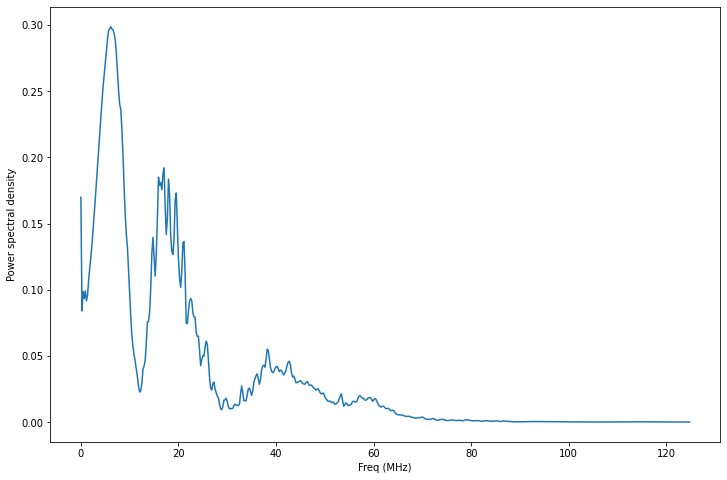

In [21]:
plot.plot_ft(cropped_lines[0])

In [49]:
filted_lines = [copy.deepcopy(line) for line in cropped_lines]
for line in filted_lines:
    line.vertical_band_pass(12, 50)

Bandpassing from 12.0 to 50.0 MHz...
Bandpass filter complete.
Bandpassing from 12.0 to 50.0 MHz...
Bandpass filter complete.
Bandpassing from 12.0 to 50.0 MHz...
Bandpass filter complete.


(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:xlabel='Freq (MHz)', ylabel='Power spectral density'>)

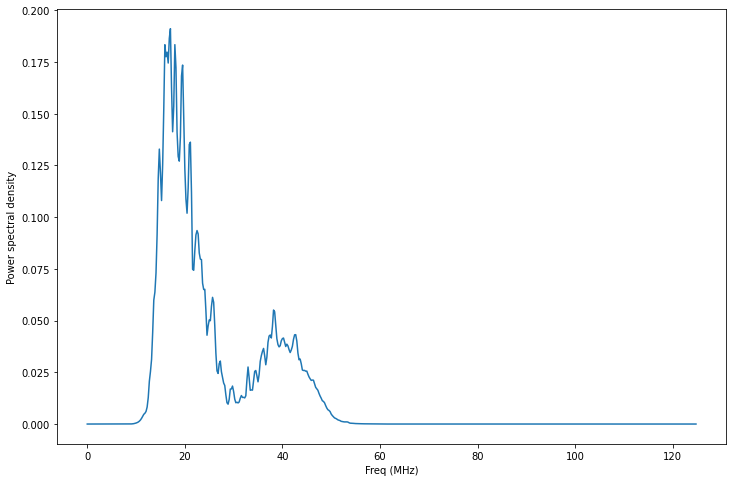

In [50]:
plot.plot_ft(filted_lines[0])

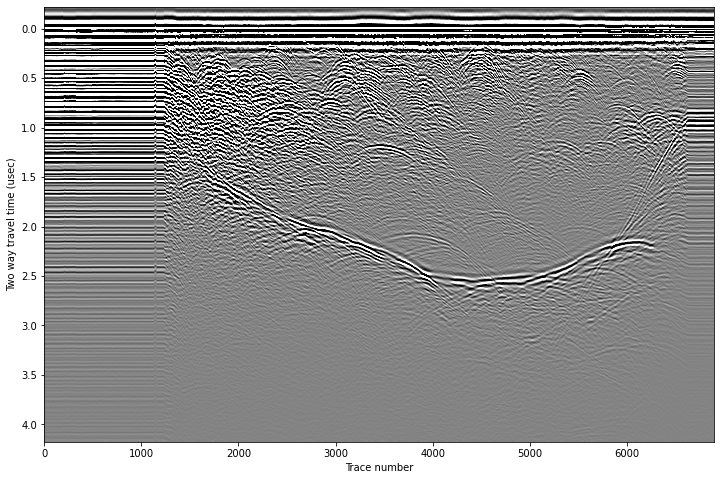

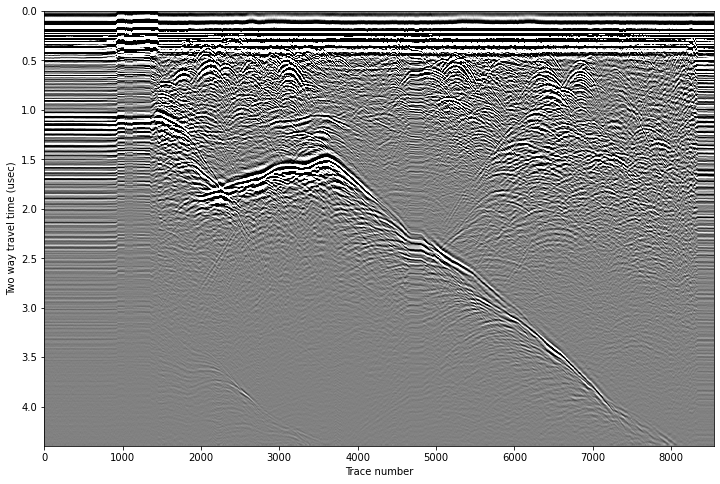

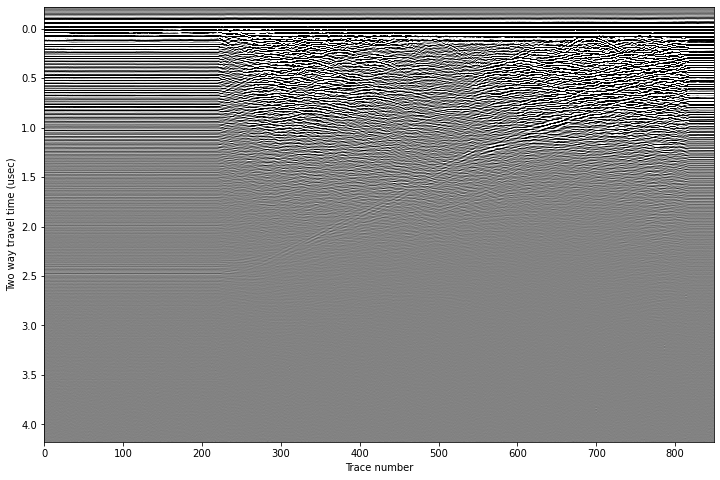

In [51]:
for line in filted_lines:
    plot.plot_radargram(line)

In [55]:
# deal with weird snum
filted_lines[-1].travel_time = np.arange(0.0, filted_lines[-1].snum, 1.0) * (filted_lines[-1].travel_time[1] - filted_lines[-1].travel_time[0])

for line in filted_lines:
    line.adaptivehfilt(100)

Adaptive filtering
Adaptive filtering complete
Adaptive filtering
Adaptive filtering complete
Adaptive filtering
Adaptive filtering complete


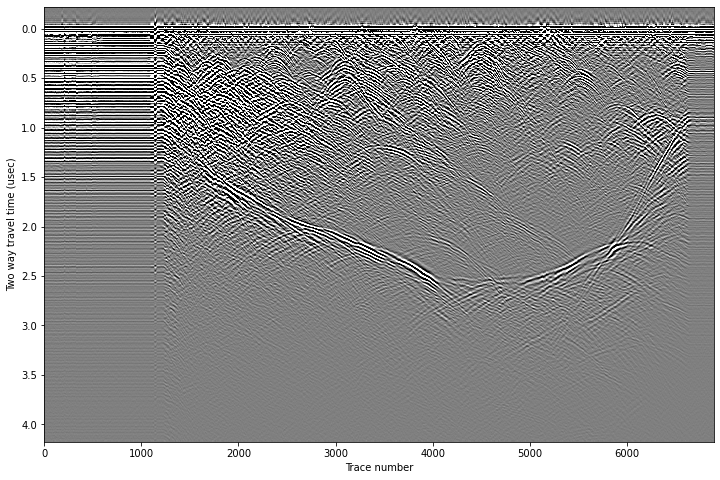

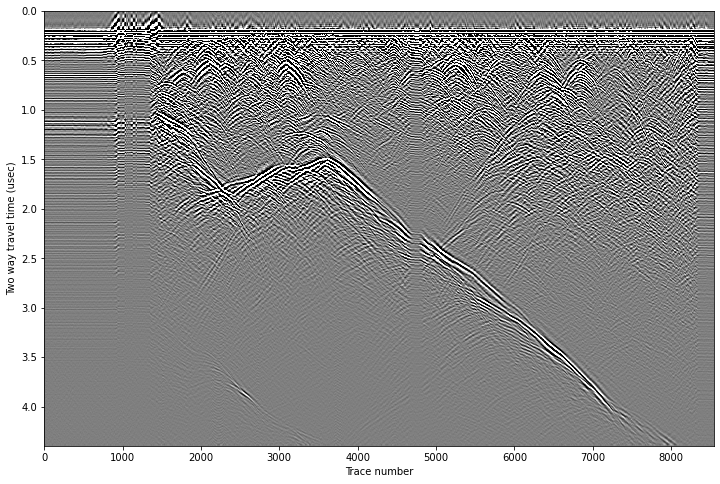

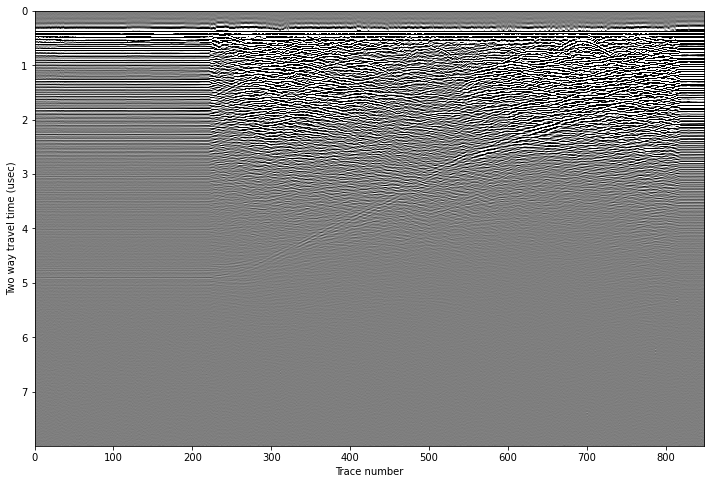

In [56]:
for line in filted_lines:
    plot.plot_radargram(line)

### Deal with stationary periods
I usually respace horizontally at this point, mainly just because the data are a bit tough to look at if we don't do this.*If we had precision GPS, we would attach it to the file (probably using the timestamp) now!* My target with this step is to preserve approximately the original number of traces (through adjusting the spacing) while excluding an stationary periods (by slowly increasing min_movement). Note that ImpDAR does this in projected coordinates--it will not be very good if you do not have GDAL.

In [28]:
spaced_lines = [copy.deepcopy(line) for line in filted_lines]
if gpslib.conversions_enabled:
    for line in spaced_lines:
        line.get_projected_coords(t_srs='EPSG:3338')
    for line in spaced_lines:
        line.constant_space(0.2, min_movement=0.05)

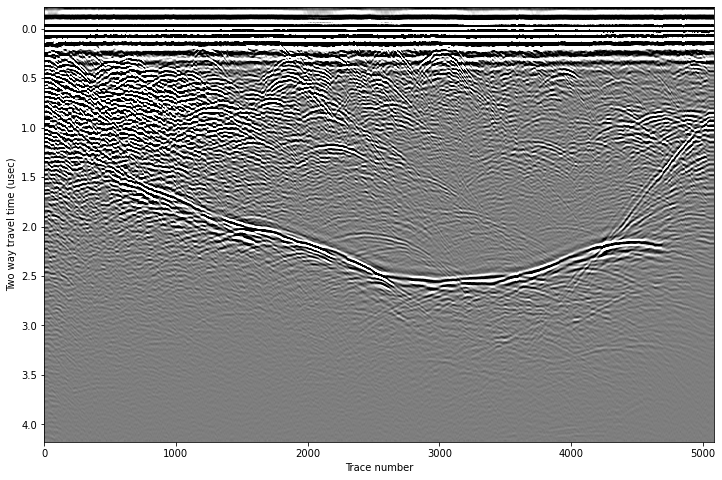

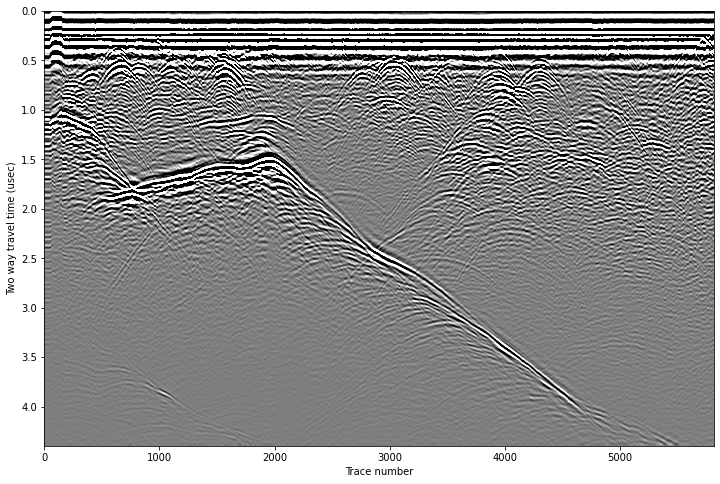

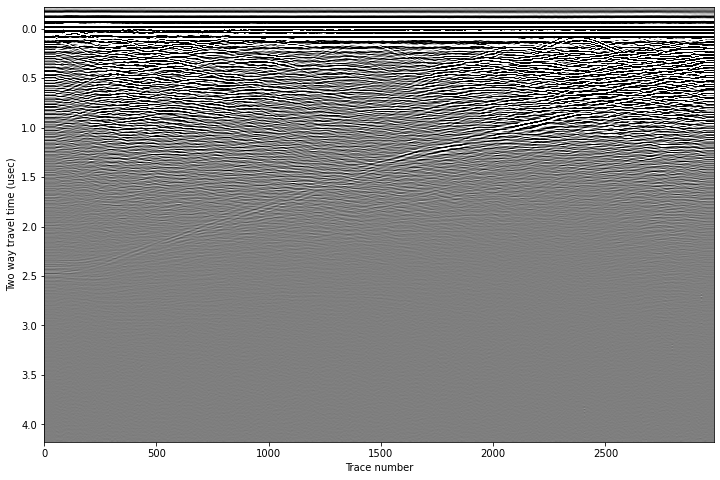

In [29]:
for line in spaced_lines:
    plot.plot_radargram(line)

### Projected coordinates
A nice side effect of having projected the coordinates is that plotting can be easier. In this case, we now match the projection of the plot from before, so we can plot without a transform. Note also that this shows us where our splitting happened in geographic space.

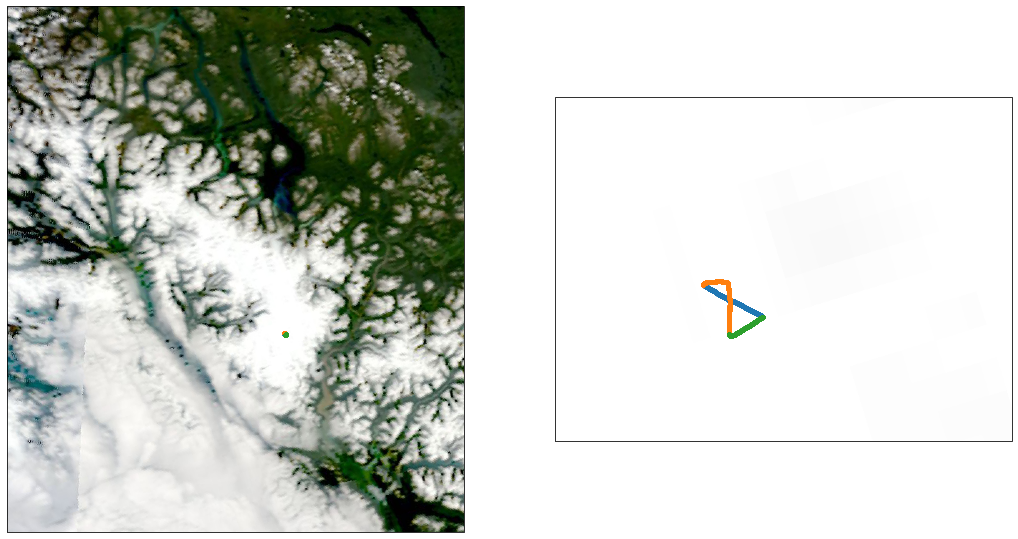

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12), subplot_kw={'projection': ccrs.epsg(3338)})
ax1.set_extent(rough_extents, crs=ccrs.PlateCarree())
ax2.set_extent(fine_extents, crs=ccrs.PlateCarree())
for ax in (ax1, ax2):
    ax.add_wmts(wmts, layer, wmts_kwargs={'time': date_str})
    for line in spaced_lines:
        ax.plot(line.x_coord, line.y_coord, linestyle='none', marker='.')